<a href="https://colab.research.google.com/github/rhobaker/Data_Project/blob/main/Main_Jupyter_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the project

The aim of our project was to examine the evidence that a proposed bill being put before the UK Parliament will be effective in reducing smoking rates in the UK.

The long title of this bill is:

> A Bill to Make provision about the supply of tobacco, vapes and other products, including provision prohibiting the sale of tobacco to people born on or after 1 January 2009; and to enable product requirements to be imposed in connection with tobacco, vapes and other products.

https://bills.parliament.uk/bills/3703

The Bill will prohibit the sale of cigarettes to people born after 2008.  Each year the age at which people can legally cigarettes will increase, resulting in people born after 31st December 2008 never being able to buy them.  This will be enforced by fining organisations who break the law.  The government believes that this will reduce the harm caused by smoking, which is still the number one cause of preventable deaths in the UK and costs the NHS £17bn a year.


https://www.bbc.co.uk/news/health-68825322#:~:text=The%20restrictions%20will%20apply%20to,able%20to%20legally%20buy%20cigarettes.



To analyse how effective this ban might be we used evidence from a number of data sources to answer two questions:

**<span style="color:darkblue">Question One:</span>**\
**How effective does historic data suggest that government mitigations have been on affecting smoking prevalence and mortality?**

**<span style="color:darkblue">Question Two:</span>**\
**Based on this analysis, how effective will the new ban be on reducing smoking prevalence and mortality?**



## <span style="color:darkblue"> Question One: </span>
### **How effective does historic data suggest that government mitigations have been on affecting smoking prevalence and mortality?**

#### <span style="border: 2px solid darkblue" padding = 500px > Analysis One:  Changes in global smoking rates compared to levels of government intervention</span>

Using data from the WHO we have analysed how effective government measures have been on reducing rates of smoking globally, in order to determine how effective government measures are in general at reducing smoking rates.


The WHO adopted the WHO Framework Convention on Tobacco Control on 21 May 2003 as a response to the global tobacco epidemic.  It uses the MPOWER package to help countries reduce their smoking rates by reducing the demand for tobacco products from their populations.  It has six different strands:


- **M**: Monitor tobacco use and prevention policies
- **P**: Protect people from tobacco smoke
- **O**: Offer help to quit tobacco use
- **W**: Warn about the dangers of tobacco
- **E**: Enforce bans on tobacco advertising, promotion and sponsorship
- **R**: Raise taxes on tobacco

https://www.who.int/initiatives/mpower

#### Data Analysis

The WHO categorises each of these strands into 5 levels to based on how well they have been implemented in each country, with 1 being the lowest level of control and 5 being the greatest.  This data is publically avaliable via an API.

We used this API to get a total score per country for each of the years it is available.  This was used to calculate a weighted mean level of implementation for the world as a whole, based on the population of each country.

By comparing this to global smoking rates, also avaliable via an API, we prepared an analysis to see if there is a relationship between the adoption of these initiatives and the global smoking rate.

https://www.who.int/data/gho/data/themes/topics/indicator-groups/indicator-group-details/GHO/tobacco-control---progress-towards-selected-tobacco-control-policies-for-demand-reduction

In [86]:
# Import all libraries needed for the project
import requests as requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests as requests
from functools import reduce

In [87]:
# Get all API data needed from the WHO and save as JSON files

# Define the urls for each of the APIs needed:
# Global smoking rates by year:
url_sr = "https://ghoapi.azureedge.net/api/M_Est_tob_curr_std?$filter=SpatialDimType%20eq%20%27GLOBAL%27"
# Levels of smoking intervention prevelance:
urlM = "https://ghoapi.azureedge.net/api/M_Group"
urlP = "https://ghoapi.azureedge.net/api/P_Group"
urlO = "https://ghoapi.azureedge.net/api/O_Group"
urlW = "https://ghoapi.azureedge.net/api/W_Group"
urlE = "https://ghoapi.azureedge.net/api/E_Group"
urlR = "https://ghoapi.azureedge.net/api/R_Group"
# World population by country:
urlpop = "https://ghoapi.azureedge.net/api/RS_1845"

#Use request module to get the API data and save in a variable:
response_sr = requests.get(url_sr)
responseM = requests.get(urlM)
responseP = requests.get(urlP)
responseO = requests.get(urlO)
responseW = requests.get(urlW)
responseE = requests.get(urlE)
responseR = requests.get(urlR)
responsepop = requests.get(urlpop)

#Turn response into JSON data:
json_data_rate = response_sr.json()
json_data_M = responseM.json()
json_data_P = responseP.json()
json_data_O = responseO.json()
json_data_W = responseW.json()
json_data_E = responseE.json()
json_data_R = responseR.json()
json_data_pop = responsepop.json()

#Check that the data has been imported and give an error message if not:
if response_sr.status_code == 200 & responseM.status_code == 200 & responseP.status_code == 200 & responseP.status_code == 200 & responseO.status_code == 200 & responseW.status_code == 200 & responseE.status_code == 200 & responseR.status_code == 200 & responsepop.status_code == 200:
    print("Data was retrieved")
else:
    print("There was an error retrieving the data")

Data was retrieved


In [88]:
# Create a panda's DataFrame for global smoking rates:

# Set empty arrays to append data into:
sr_value = [] # For rates
sr_time = [] # For years

# Loop through the API data and append data to the empty arrays
for i in json_data_rate["value"]:
    if i["Dim1"] == "SEX_BTSX":  # Data for both sexes together
        sr_value.append(i["NumericValue"])
        sr_time.append(i['TimeDimensionValue'])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(sr_time, sr_value))
label = ["Year", "Smoking Rate"]

#Create the DataFrame
df_rate = pd.DataFrame(data, columns = label)
# Turn the data into numeric values for calculations to be performed and graphs produced
df_rate = df_rate.apply(pd.to_numeric, errors='coerce')
# Set the year as the DataFrame's index
df_rate = df_rate.set_index("Year")
# Check the result
df_rate

,Smoking Rate
Year,
2007,28.1
2000,32.7
2030,18.1
2005,29.3
2021,21.3
2010,26.4
2022,20.9
2018,22.5
2015,23.9


In [89]:
# Create a panda's DataFrame for population data:

# Set empty arrays to append data into
indexpop = [] # For the country code
valuepop = [] # For the population

# Loop through API data and append values to the empty arrays
for i in json_data_pop["value"]:
    indexpop.append(i["SpatialDim"])
    valuepop.append(i["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(indexpop, valuepop))
label = ["Code", "Population"]

# Create the DataFrame
df_pop = pd.DataFrame(data, columns = label)

# Clean the spaces out of the numerical data in order to be able to use it for a calculation
df_pop['Population'] = df_pop['Population'].str.replace(' ', '')

# Turn the population value into an integer so it can be used for a calculation
df_pop["Population"] = pd.to_numeric(df_pop["Population"])

# Set the Code column to the DataFrame index
df_pop = df_pop.set_index("Code")
# Check the result
df_pop

,Population
Code,
ARM,3092072
ZMB,13088570
POL,38276660
IRL,4469900
MLI,15369809
...,...
BRA,194946488
GEO,4352244
PRK,24346229


In [90]:
# Calculate the total global population and save in a variable for use in the weighted mean calculation
total_pop = sum(df_pop["Population"])
total_pop

6787737744

In [91]:
# Create a panda's DataFrame for MPOWER data:

# Set empty arrays to append data into:
mpower_index = [] # For the country code
mpower_time = [] # For the year
mpower_value = [] # For the value

# Create a list of all files to append data for:
List_of_json = [json_data_M, json_data_P, json_data_O, json_data_W, json_data_E, json_data_R]

for i in List_of_json:
    for j in i["value"]:
        mpower_index.append(j["SpatialDim"])
        mpower_time.append(j["TimeDimensionValue"])
        mpower_value.append(j["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(mpower_index, mpower_time, mpower_value))
label = ["Code", "Year", "Value"]

# Create the DataFrame
df_MPOWER = pd.DataFrame(data, columns = label)
# Replace "Not applicable" with 1 - the lowest level possible
df_MPOWER = df_MPOWER.replace("Not applicable", 1)

# Turn column "Value" into numeric to be able to calculate the mean
df_MPOWER["Value"] = df_MPOWER["Value"].apply(pd.to_numeric, errors='coerce')

# Create a DataFrame of a pivot table to get the total MPOWER score for each country
df_MPOWER_pivot = pd.DataFrame(df_MPOWER.pivot_table(values='Value', index="Code", columns = "Year", aggfunc = np.sum))
# Check the result
df_MPOWER_pivot


Year,2007,2008,2010,2012,2014,2016,2018,2020,2022
Code,,,,,,,,,
AFG,14,15,15,15,17,21,19,19,18
AGO,11,12,12,13,13,12,16,16,16
ALB,19,24,24,25,24,24,24,25,25
AND,13,12,15,17,17,17,18,18,18
ARE,15,19,20,22,22,21,24,24,23
...,...,...,...,...,...,...,...,...,...
WSM,13,20,20,20,23,24,23,22,22
YEM,16,19,18,19,22,22,22,21,20
ZAF,15,17,18,18,19,19,17,17,18


In [92]:
# Merge pivot tables with population
# Inner merge used in order to only have data where there is a poplulation number
merged_dataframe = pd.merge(df_pop, df_MPOWER_pivot, left_index=True, right_index=True, how='inner')
merged_dataframe

,Population,2007,2008,2010,2012,2014,2016,2018,2020,2022
Code,,,,,,,,,,
ARM,3092072,16,17,17,19,20,21,21,25,25
ZMB,13088570,13,16,15,16,16,16,17,17,17
POL,38276660,18,22,23,23,23,25,25,25,25
IRL,4469900,22,26,26,27,27,28,28,28,28
MLI,15369809,12,14,16,17,15,17,17,17,16
...,...,...,...,...,...,...,...,...,...,...
BRA,194946488,19,22,22,27,28,28,29,29,29
GEO,4352244,15,17,17,18,19,20,25,25,24
PRK,24346229,12,13,14,14,15,16,16,16,16


In [93]:
# Multiply population by MPOWER score for the weighted mean calculation:

# Create a list of the years
df_MPOWER_pivot_columns = list(df_MPOWER_pivot.columns)

# Loop through the columns and multiply population by total MPOWER score
for i in df_MPOWER_pivot_columns:
    merged_dataframe[i] = merged_dataframe[i] * merged_dataframe["Population"]
merged_dataframe

,Population,2007,2008,2010,2012,2014,2016,2018,2020,2022
Code,,,,,,,,,,
ARM,3092072,49473152,52565224,52565224,58749368,61841440,64933512,64933512,77301800,77301800
ZMB,13088570,170151410,209417120,196328550,209417120,209417120,209417120,222505690,222505690,222505690
POL,38276660,688979880,842086520,880363180,880363180,880363180,956916500,956916500,956916500,956916500
IRL,4469900,98337800,116217400,116217400,120687300,120687300,125157200,125157200,125157200,125157200
MLI,15369809,184437708,215177326,245916944,261286753,230547135,261286753,261286753,261286753,245916944
...,...,...,...,...,...,...,...,...,...,...
BRA,194946488,3703983272,4288822736,4288822736,5263555176,5458501664,5458501664,5653448152,5653448152,5653448152
GEO,4352244,65283660,73988148,73988148,78340392,82692636,87044880,108806100,108806100,104453856
PRK,24346229,292154748,316500977,340847206,340847206,365193435,389539664,389539664,389539664,389539664


In [94]:
# Add up each column in the table

# Set empty arrays to append data into:
total_year = []
total_mean = []

# Loop through the and append the weighted mean to the empty arrays
for i in df_MPOWER_pivot_columns:
    total_year.append(i)
    total_mean.append(merged_dataframe[i].sum()/total_pop)

# Create lists for the data needed in the DataFrame
data = list(zip(total_year, total_mean))

# Create a DataFrame of the weighted mean by year
mean_by_year = pd.DataFrame(data, columns = ["Year", "Weighted Mean MPOWER"])
# Turn all data into numeric values in order to plot them on the graph
mean_by_year = mean_by_year.apply(pd.to_numeric, errors='coerce')
# Set year as the index to merge with smoking rates
mean_by_year = mean_by_year.set_index("Year")
# Check the DataFrame
mean_by_year

,Weighted Mean MPOWER
Year,
2007,15.185550
2008,18.812244
2010,19.041077
2012,19.873850
2014,20.900575
2016,21.946641
2018,22.497117
2020,22.687553
2022,22.782868


In [95]:
# Merge weighted mean with smoking rate
# Use outer merge as we want to plot data for all of the years
merged_rate_MPOWER = pd.merge(mean_by_year, df_rate, left_index=True, right_index=True, how='outer')
# Drop future years and past years without MPOWER data
cleaned_merged_rate_MPOWER = merged_rate_MPOWER.drop([2000, 2005,2025, 2030])
# Check result
cleaned_merged_rate_MPOWER

,Weighted Mean MPOWER,Smoking Rate
Year,,
2007,15.185550,28.1
2008,18.812244,NaN
2010,19.041077,26.4
2012,19.873850,NaN
2014,20.900575,NaN
2015,NaN,23.9
2016,21.946641,NaN
2018,22.497117,22.5
2020,22.687553,21.7


#### Calculate the Correlation

In [96]:
# Calculate the correlation
print(merged_rate_MPOWER.corr())

                      Weighted Mean MPOWER  Smoking Rate
Weighted Mean MPOWER              1.000000     -0.963532
Smoking Rate                     -0.963532      1.000000


#### Plot the relationship

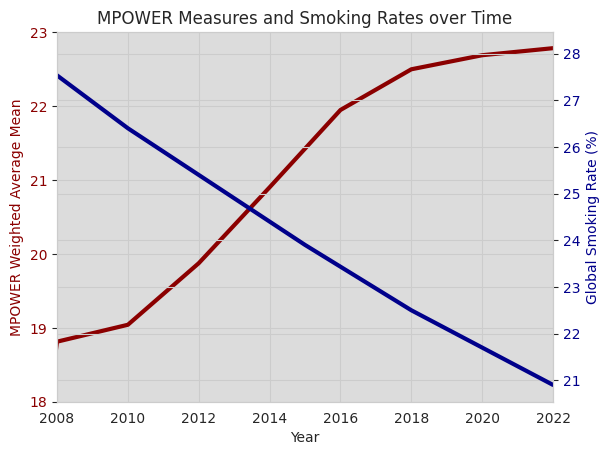

In [104]:
# Create a mask to smooth the data into a line as not all years have data
ratemask = np.isfinite(cleaned_merged_rate_MPOWER["Smoking Rate"])
MPOWERmask = np.isfinite(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"])

# Create the plot and set the axis values
fig, ax1 = plt.subplots()
plt.xlim(2008, 2022)
plt.ylim(18, 23)
ax1.set_facecolor("gainsboro")

# Plot the MPOWER values
ax1.set_xlabel('Year')
ax1.set_ylabel('MPOWER Weighted Average Mean', color = 'darkred')
ax1.plot(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"][MPOWERmask], color = 'darkred', lw = 3)
ax1.tick_params(axis ='y', labelcolor = 'darkred')


# Adding Twin Axes to plot smoking rates
ax2 = ax1.twinx()
ax2.set_ylabel('Global Smoking Rate (%)', color = "darkblue")
ax2.plot(cleaned_merged_rate_MPOWER["Smoking Rate"][ratemask], linestyle='-', color = "darkblue", lw=3)
ax2.tick_params(axis ='y', labelcolor = "darkblue")

# Adding title
plt.title('MPOWER Measures and Smoking Rates over Time')

# Show plot
plt.show()

#### Conclusion
The data shows that there is a clear correlation globally between the number of measures in place to reduce demand for tobacco and the smoking rate.
This demonstrates that there is evidence that increasing the measures in place to reduce demand for tobacco products reduces smoking rates.

## Analysis for the UK

The next step in our analysis was to determine if this global trend was also seen in the UK.
Over the last twenty years there has been increasing legal measures implemented by successive UK governments to reduce the rate of smoking.
A summary of these is outlined below:

### Timeline of key government legislation and regulation

<img src="https://github.com/rhobaker/Data_Project/blob/main/Smoking_actions_timeline.png?raw=true" width="900" height="450"/>

https://news.cancerresearchuk.org/2023/03/07/ending-smoking-could-free-up-gp-appointments/

In [98]:
import pandas as pd

# Load the CSV file
file_path = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_smoking_habits_in_the_uk_and_its_constituent_countries/Table_1.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
data.head()

,Sex,Country code,Country,Age group,2022 \nCurrent smokers \n%,2022 \nCurrent smokers \nLCL,2022 \nCurrent smokers \nUCL,2022 \nEx-smokers \n%,2022 \nEx-smokers \nLCL,2022 \nEx-smokers \nUCL,...,2011 \nCurrent smokers \nLCL,2011 \nCurrent smokers \nUCL,2011 \nEx-smokers \n%,2011 \nEx-smokers \nLCL,2011 \nEx-smokers \nUCL,2011 \nNever smoked \n%,2011 \nNever smoked \nLCL,2011 \nNever smoked \nUCL,2011 \nWeighted count \n[note 2],2011 \nSample size \n[note 3]
0,Persons,E92000001,England,18-24,11.6,10.5,12.7,5.8,5.1,6.5,...,24.9,26.6,14.6,14.0,15.3,59.6,58.6,60.6,"4,534,797","16,005"
1,Persons,E92000001,England,25-34,16.3,15.4,17.2,15.5,14.7,16.3,...,25.0,26.3,25.5,24.8,26.2,48.9,48.1,49.7,"6,603,723","24,919"
2,Persons,E92000001,England,35-44,14.4,13.6,15.2,22.4,21.6,23.2,...,22.4,23.5,29.6,28.9,30.2,47.5,46.8,48.2,"6,894,388","29,500"
3,Persons,E92000001,England,45-54,13.9,13.2,14.6,27.3,26.5,28.2,...,20.4,21.5,31.1,30.5,31.7,48.0,47.3,48.7,"6,889,642","30,608"
4,Persons,E92000001,England,55-64,13.2,12.5,13.9,28.6,27.8,29.4,...,17.3,18.4,41.5,40.8,42.1,40.7,40.0,41.4,"5,887,006","29,270"


In [99]:
# Clean the column names
data.columns = data.columns.str.replace('\n', '').str.replace(' ', '_').str.replace('__', '_').str.strip()
# Adjusted column names based on the inspection
columns_of_interest = [
    'Country', 'Sex', 'Age_group',
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

# Select relevant columns for the year 2022
data_2022 = data[columns_of_interest].copy()
data_2022

,Country,Sex,Age_group,2022_Current_smokers_%,2022_Current_smokers_LCL,2022_Current_smokers_UCL,2022_Ex-smokers_%,2022_Ex-smokers_LCL,2022_Ex-smokers_UCL,2022_Never_smoked_%,2022_Never_smoked_LCL,2022_Never_smoked_UCL
0,England,Persons,18-24,11.6,10.5,12.7,5.8,5.1,6.5,82.5,81.3,83.8
1,England,Persons,25-34,16.3,15.4,17.2,15.5,14.7,16.3,68.2,67.1,69.3
2,England,Persons,35-44,14.4,13.6,15.2,22.4,21.6,23.2,63.2,62.2,64.2
3,England,Persons,45-54,13.9,13.2,14.6,27.3,26.5,28.2,58.8,57.8,59.8
4,England,Persons,55-64,13.2,12.5,13.9,28.6,27.8,29.4,58.2,57.3,59.1
...,...,...,...,...,...,...,...,...,...,...,...,...
100,United Kingdom,Women,35-44,11.9,11.1,12.7,21.4,20.4,22.4,66.7,65.6,67.9
101,United Kingdom,Women,45-54,12.3,11.6,13.1,26.3,25.3,27.3,61.4,60.3,62.5
102,United Kingdom,Women,55-64,12.7,12.0,13.5,26.1,25.2,27.0,61.2,60.2,62.1
103,United Kingdom,Women,65+,7.8,7.3,8.2,32.1,31.4,32.8,60.1,59.4,60.9


In [100]:
# Convert percentage columns to numeric
percentage_columns = [
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

for col in percentage_columns:
    data_2022[col] = pd.to_numeric(data_2022[col], errors='coerce')

# Check for missing data
missing_data_summary = data_2022.isnull().sum()
print(missing_data_summary)

Country                     0
Sex                         0
Age_group                   0
2022_Current_smokers_%      0
2022_Current_smokers_LCL    0
2022_Current_smokers_UCL    0
2022_Ex-smokers_%           0
2022_Ex-smokers_LCL         0
2022_Ex-smokers_UCL         0
2022_Never_smoked_%         0
2022_Never_smoked_LCL       0
2022_Never_smoked_UCL       0
dtype: int64


In [101]:
# Display the cleaned column names
print(data.columns.tolist())

# Extract the years present in the dataset based on column names
years = list(set([col.split('_')[0] for col in data.columns if col.split('_')[0].isdigit()]))
print("Years found in the dataset:", years)

# List of smoking status categories
smoking_statuses = ['Current_smokers_%', 'Ex-smokers_%', 'Never_smoked_%']

# Correct column names for melting
columns_to_melt = {}
for status in smoking_statuses:
    columns_to_melt[status] = [col for col in data.columns if status in col]

print("Columns to melt for each status:", columns_to_melt)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each smoking status to melt the data
for status, status_cols in columns_to_melt.items():
    status_df = data.melt(id_vars=['Country', 'Sex'],
                          value_vars=status_cols,
                          var_name='Year_Status',
                          value_name=status)

    # Extract year from the combined Year_Status column
    status_df['Year'] = status_df['Year_Status'].str.extract('(\d{4})').astype(int)

    # Drop the Year_Status column
    status_df = status_df.drop(columns=['Year_Status'])

    # Append the melted dataframe to the list
    dfs.append(status_df)

# Merge the dataframes on common columns
data_long = dfs[0]
for df in dfs[1:]:
    data_long = pd.merge(data_long, df, on=['Country', 'Sex', 'Year'])

print(data_long.head())

['Sex', 'Country_code', 'Country', 'Age_group', '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL', '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL', '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL', '2022_Weighted_count_[note_2]', '2022_Sample_size_[note_3]', '2021_Current_smokers_%', '2021_Current_smokers_LCL', '2021_Current_smokers_UCL', '2021_Ex-smokers_%', '2021_Ex-smokers_LCL', '2021_Ex-smokers_UCL', '2021_Never_smoked_%', '2021_Never_smoked_LCL', '2021_Never_smoked_UCL', '2021_Weighted_count_[note_2]', '2021_Sample_size_[note_3]', '2020_Current_smokers_%', '2020_Current_smokers_LCL', '2020_Current_smokers_UCL', '2020_Ex-smokers_%', '2020_Ex-smokers_LCL', '2020_Ex-smokers_UCL', '2020_Never_smoked_%', '2020_Never_smoked_LCL', '2020_Never_smoked_UCL', '2020_Weighted_count_[note_2]', '2020_Sample_size_[note_3]', '2019_Current_smokers_%', '2019_Current_smokers_LCL', '2019_Current_smokers_UCL', '2019_Ex-smokers_%', 

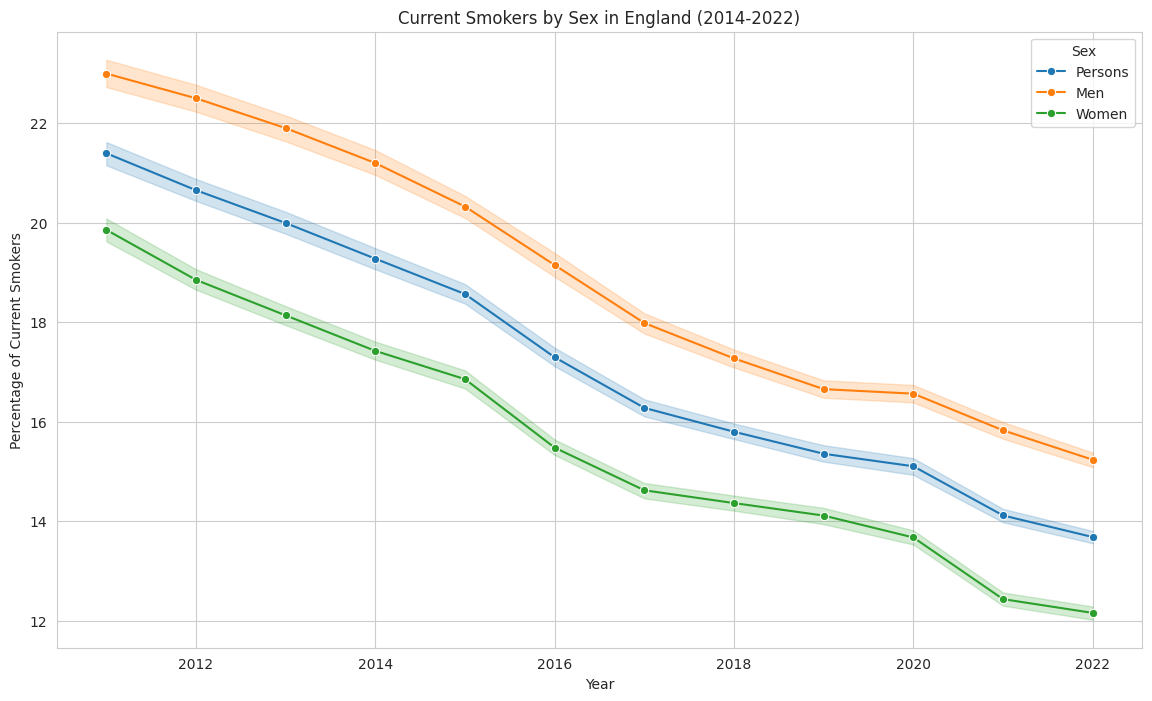

In [102]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create line plots for each smoking category by Sex
smoking_categories = ['Current_smokers_%']
titles = ['Current Smokers']

for category, title in zip(smoking_categories, titles):
    plt.figure(figsize=(14, 8))
    sns.lineplot(x='Year', y=category, hue='Sex', data=data_long, marker='o')
    plt.title(f'{title} by Sex in England (2014-2022)')
    plt.ylabel(f'Percentage of {title}')
    plt.xlabel('Year')
    plt.legend(title='Sex')
    plt.show()

#### <span style="border: 2px solid darkblue" padding = 500px > Analysis XX: Changes in e-cigarette use</span>

The proposed ban focuses on reducing smoking rates, but also acknowledges the issue of the use of e-cigarettes (a.k.a. vaping). Although e-cigarettes don't contain tobacco, the key factor causing cancer, they are not risk-free. The NHS recommends that young people should not take up vaping, a key concern, particularly with attractive 'flavours' such as fruit and sweets. The long-term side-effects of vaping are still unknown.

In order to analyse the effect e-cigarettes may have on smoking rates, we analysed the Office for National Statistics and NHS publicly available datasets on 'E-cigarette use in Great Britain', 'Adult smoking habits in Great Britain' and 'Smoking, drinking and drug use among young people'.

Recency in the datasets prevents us from analysing reported recent significant changes in e-cigarette use; the adult dataset goes up to 2022 but the youth set only up to 2021. To mitigate this, we have taken a small amount of data from written documents (all that was available) of the ASH Smokefree GB youth survey 2023.


#### Overall e-cigarette rates

In [103]:
#Import vaping dataset
url = ("/Users/rhonabaker/CFG/GROUP PROJECT/GitHub/GitHub repository/ONS_ecigarette_use_in_great_britain/table1abc_cleaned.csv")

vapers = pd.read_csv(url)

vapers.drop(['Unnamed: 0'], axis=1, inplace=True)

vapers.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rhonabaker/CFG/GROUP PROJECT/GitHub/GitHub repository/ONS_ecigarette_use_in_great_britain/table1abc_cleaned.csv'

In [ ]:
#Create a lineplot of overall e-cig users over time
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
ax3 = sns.lineplot(x="Year", y="All 16+", data=vapers, lw=3, color="darkblue")

ax3.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as E-cigarette users')

ax3.set_yticks(range(3,10))
ax3.set_yticklabels(range(3,10))

sns.set_style("darkgrid")

We can see here that there has been a clear continual rise in the use of e-cigarettes, increasing more post-2019. This however is a relatively small scale up to 10% - let's compare it with the scale of smoking rates.

#### E-cigarette vs smoking prevalence

In [ ]:
#import smokers data

url = ("/Users/rhonabaker/CFG/GROUP PROJECT/GitHub/GitHub repository/ONS_adult_smoking_habits_in_great_britain/Table_1a-Table_1_cleaned.csv")
smokers = pd.read_csv(url)

smokers.drop(['Unnamed: 0'], axis=1, inplace=True)
smokers.head()

In [ ]:
#Extract just the data for overall figures
smokers_all = smokers[['Year','All 16+']]

#We need to convert the data from wide into long format to make a multi-line plot in seaborn. We will use the melt method:
smokers_melt = pd.melt(smokers_all, id_vars="Year")

#Extract only the years also available for e-cig data
smokers_melt = smokers_melt[:9]

#Clean up long form table
smokers_melt['variable'].replace('All 16+', 'Smokers', inplace=True)
smokers_melt.rename(columns={"value": "Proportion", "variable": "Type"}, inplace=True)
smokers_melt.head()

In [ ]:
#Extract just overall figures for vapers
vapers_all = vapers[['Year','All 16+']]

#Convert to long format
vapers_melt = pd.melt(vapers_all, id_vars="Year")

#Clean up long table
vapers_melt['variable'].replace('All 16+', 'Vapers', inplace=True)
vapers_melt.rename(columns={"value": "Proportion", "variable": "Type"}, inplace=True)
vapers_melt.head()

#Combine smokers and vapers into one table to visualise
smokers_vapers_all = pd.concat([smokers_melt, vapers_melt], ignore_index=True)

In [ ]:
#Multi-line plot of smoking rates vs e-cig rates over time

plt.figure(figsize=(9, 6))

ax4= sns.lineplot(data=smokers_vapers_all, x='Year', y='Proportion', hue='Type', palette=['darkblue', 'darkred'], lw=3)

ax4.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as smokers and e-cigarette users')

ax4.set_yticks(range(3,21))
ax4.set_yticklabels(range(3,21))

ax4.legend_.set_title(None)

In [ ]:
#Correlation coefficient
import numpy as np

smokers_arr = np.array(smokers['All 16+'].loc[:8])
vapers_arr = np.array(vapers['All 16+'].loc[:8])

smoke_vape_coeff = np.corrcoef(smokers_arr, vapers_arr)
smoke_vape_coeff

We can see a clear steady negative correlation between smoking and e-cigarette use. The general e-cig rate remains below the smoking rate.

These are however average rates across all age ranges. We often see reports and warnings about the risks of vaping in young people. Let's look at e-cigarette usage by age category - which in this dataset is for ages 16+:

#### E-cigarette use by age category

In [ ]:
#Vapers by age category
vapers_ages = vapers[["Year", "All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+"]]

#Convert to long format
v_ages_melt = pd.melt(vapers_ages, id_vars="Year")
v_ages_melt.head()

#Clean up long table
v_ages_melt.rename(columns={"variable": "Age_group", "value": "Proportion"}, inplace=True)

In [ ]:
#Multi-line plot on e-cig use over time by age group
plt.figure(figsize=(9, 6))
ax5 = sns.lineplot(x='Year', y='Proportion', hue='Age_group', data=v_ages_melt, lw=2)

ax5.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as E-cigarette users by age group',)

ax5.set_yticks(range(1,17))
ax5.set_yticklabels(range(1,17))

plt.legend(title='Age group')

#Renaming labels messing up legend?
# plt.legend(labels=["16-24", "25-34", "35-49", "50-59", "60+"])

When analysing by age group, we can see that ages 35-59 increase steadily, 25-34 increases more quickly over time, and 60+ doesn't show much growth, with vaping being less popular with the older population. However post 2019 we can see a dramatic increase in the 16-24 age group, which was responsible for bringing up the steeper general increase in the overall trend.

We can also look at this data in box plots over time, to see how the distribution of the proportion for each age group affects the overall e-cigarette use rate for each year:

In [ ]:
#Box plot to show distribution of age group values each year
plt.figure(figsize=(9, 6))
ax6 = sns.boxplot(x = 'Year', y = 'Proportion', data = v_ages_melt, width=.5, palette="hls")

ax6.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as E-cigarette users: distribution by age group',)

ax6.set_yticks(range(1,17))
ax6.set_yticklabels(range(1,17))

Here we can see that the large distribution differences in our age groups mean we should not make assumptions on the e-cigarette rate in general; clearly the spike in e-cigarette use is due to a rise in the younger generation.

Looking further into trends within age groups, let's look at a snapshot of e-cigarette users compared to smokers in each age group in our most recent year of data, 2022:

#### E-cigarette vs smoking prevalence by age category

In [ ]:
#Extract smokers ages
smokers_ages = smokers[['All 16-24', 'All 25-34', 'All 35-49', 'All 50-59', 'All 60+']]
#Extract just 2022 smokers
smoke22 = smokers_ages.loc[0].to_frame()
#Clean up dataframe
smoke22.insert(0, 'Type', 'Smokers')
smoke22 = smoke22.reset_index()
smoke22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
smoke22.head()

#Extract just 2022 vapers
vape22 = vapers_ages.loc[0].to_frame()
#Clean up dataframe
vape22.insert(0, 'Type', 'Vapers')
vape22 = vape22.reset_index()
vape22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
vape22 = vape22.drop(0, axis='index')
vape22.head()

#Combine vaper and smoker dfs
combined22 = pd.concat([smoke22, vape22], ignore_index=True)
combined22.head()

In [ ]:
#Bar plot of smoking and e-cig use by age group in 2022

plt.figure(figsize=(9, 6))
ax7 = sns.barplot(combined22, x="Age_group", y="Proportion", hue="Type", palette='hls')

ax7.set(xlabel='Age group',
       ylabel='Proportion of population (%)',
       title='Proportion of smokers and e-cig users by age group in 2022',)

ax7.legend_.set_title(None)

Here we can see that smoking rates do not have a clear correlation to vaping rates between age groups. Smoking rates vary between age groups, but vaping has a clear trend of higher use the younger the age group. Younger people may have higher usage because of the attractiveness of vaping, not just as a tool to quit smoking as their smoking rates are lower than most of the other age groups. We can look again at the proportion of ecig users to vapers over time, but just with the 16-24 age group:

#### E-cigarette vs smoking prevalence in young people

In [ ]:
#Extract just the data for 16-24 smokers overall
smokers_young = smokers[['Year','All 16-24']]

#We need to convert the data from wide into long format to make a multi-line plot in seaborn. We will use the melt method:
smokers_young_melt = pd.melt(smokers_young, id_vars="Year")

#Extract only the years also available for e-cig data
smokers_young_melt = smokers_young_melt[:9]

#Clean up long form table
smokers_young_melt['variable'].replace('All 16-24', 'Smokers', inplace=True)
smokers_young_melt.rename(columns={"value": "Proportion", "variable": "Type"}, inplace=True)
smokers_young_melt.head()

In [ ]:
#Extract just 16-24 overall figures for vapers
vapers_young = vapers[['Year','All 16-24']]

#Convert to long format
vapers_young_melt = pd.melt(vapers_young, id_vars="Year")

#Clean up long table
vapers_young_melt['variable'].replace('All 16-24', 'Vapers', inplace=True)
vapers_young_melt.rename(columns={"value": "Proportion", "variable": "Type"}, inplace=True)
vapers_young_melt.head()

#Combine smokers and vapers into one table to visualise
smokers_vapers_young_all = pd.concat([smokers_young_melt, vapers_young_melt], ignore_index=True)

In [ ]:
#Multi-line plot of smoking rates vs e-cig rates over time in 16-24

plt.figure(figsize=(9, 6))

ax8= sns.lineplot(data=smokers_vapers_young_all, x='Year', y='Proportion', hue='Type', palette=['purple', 'blue'], lw=3)

ax8.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as smokers and e-cigarette users')

ax8.set_yticks(range(0,25))
ax8.set_yticklabels(range(0,25))

ax8.legend_.set_title(None)

In [ ]:
#Correlation coefficient
smokers_young_arr = np.array(smokers['All 16-24'].loc[:8])
vapers_young_arr = np.array(vapers['All 16-24'].loc[:8])

smoke_vape_young_coeff = np.corrcoef(smokers_young_arr, vapers_young_arr)
smoke_vape_young_coeff

Here we can see a slightly lower negative correlation between the rates, where from 2018-2019 smoking rates in young people started to steeply go down whilst e-cigarette rates steeply went up, showing in combination with the previous bar chart that although lower smoking rates in young people is encouraging, e-cigarette use has surpassed the smoking rate in young people, further suggesting that vaping in young people is not just being used to quit smoking and the rate will likely continue to increase without further measures.

#### E-cigarette use in youths 17 and under

What about data for those those under 16? The data we have for GB youth on smoking and vaping, aged 11-15, only goes up to the year 2021. The differences in data have too low figures over time to make an effective visualisation. We will however note the 2021 statistics here:

In 2021 smoking rates for the 11-15 year olds were **1% for regular smokers** and **1% for occasional smokers**. E-cigarette use was **4% for regular users** and **4% for occassional users**.

We won't use the written figures from the ASH GB Smokefree youth survey to look at increase in rates in more recent years, as we don't have the raw data and the written report statistics differ from our more comprehensive ONS youth dataset.

One of the key concerns in recent years is the rise in disposable vapes, particularly their use by young people. The UK government plans to ban these as part of the proposed bill, with Scotland having a confirmed date of banning disposable vapes from 1 April 2025. We can reliably look at our small amount of data from the Ash smokefree GB youth survey to look at the use of disposable vapes in more recent years:

In [ ]:
#Import e-cig device type data
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/Most_freq_used_e-cig_by_device_type_gb_youth.csv")
disposable = pd.read_csv(url)

disposable

In [ ]:
#Stacked bar plot for e-cig use by device

x = disposable['Year']
y1 = disposable['Non-disposable']
y2 = disposable['Disposable']

plt.bar(x, y1, color='cornflowerblue')
plt.bar(x, y2, bottom=y1, color='salmon')

plt.xticks([2020, 2021, 2022, 2023])
plt.legend([])

plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("Most frequently used e-cigarette by device type in e-cig users aged 11-17")
plt.legend(['Non-disposable', 'Disposable'])
plt.show()

We can see a dramatic rise, with the vast majority of young people using disposable vapes for their most frequent e-cigarette use.

## Conclusion

Although evidence shows that government mitigations are effective in bringing down smoking rates, the rise in e-cigarette use is a concern. A steady rise in use as expected as smoking rates decrease and e-cigarettes are used as quitting tools or less harmful alternatives to smoking. However the very sharp increase of e-cigarette use in younger people is far above the expected rate, considerably higher than the recent smoking rate in this demographic. Government mitigations on vaping should therefore be focussed on young people; without mitigations the rate of vaping in young people could rise exponentially.

The planned ban on disposable vapes is likely to reduce the e-cigarette usage rate in young people, with an overwhelming majority of those 11-17 using disposable vapes most frequently, although this will also benefit other age groups. The UK government have stated that alongside banning disposable vapes, measures will be brought forward to to restrict vape flavours, displays and packaging, to make them less attractive to children. Our MPOWER analysis shows that government mitigations effectively reduced smoking rates by including measures on displays and advertising, therefore this ban is likely to be effective and curb the rise in the vaping rate in young people by introducing restrictions in these areas, particularly as vaping flavours and colours are more attractive to younger people.


In [ ]:
## Question Two:
Based on this analysis, how effective will the new ban be on reducing smoking prevalence and mortality?